In [19]:
import os
import pathlib
from copy import deepcopy
import scipy.io as spio
from scipy.signal import resample

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import config
from dataset import MAX_LENGTH, FREQ_BINS, merge_df_2, calculate_features
from dataset import Df_dict, train_dataset, unlabeled_dataset, val_dataset, full_dataset


Training with 751 patients!



/opt/conda/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [3]:
from model import MHA_LSTM_simpler

from train_validate_test import load_student_teacher_both, test
from metric import*

In [4]:
MAX_LENGTH

298

In [5]:
model_folder = pathlib.Path("/Data1/hmd2/notebooks_th/AttnLSTM_exp/exps/2024-10-25_21:22:11")
data_folder = pathlib.Path("/Data2/murmur/train")
test_data_folder = pathlib.Path("/Data2/murmur/test")

# Student, Teacher
student = MHA_LSTM_simpler()
teacher = deepcopy(student)

model_name = type(student).__name__

# Load parameters
student, teacher = load_student_teacher_both(model_folder, model_name)

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
GPU_NUM = 0
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu') 
torch.cuda.set_device(device)

In [37]:
a = 10
len = 3


if a % len:
    b = len * ((a//len) + 1)
b

12

In [82]:


# def predict_single_model(eval_recording_df, data_folder, model, device):

test_patient_df, test_recording_df = Df_dict["test_patient_df"], Df_dict["test_recording_df"]


sampling_rate = config.sampling_rate

student = student.to(device)
test_results = {}

for filename in test_recording_df.index:
    
    per_file_probs = []
    
    filepath = test_data_folder / filename
    sr, recording = spio.wavfile.read(filepath.with_suffix(".wav"))
    
    if sr != sampling_rate:
        num_samples = int(len(recording) * sampling_rate / sr)
        recording = resample(recording, num_samples)
    recording = torch.as_tensor(recording.copy())
    
    mel, _ = calculate_features(recording, sampling_rate)
    mel = mel.unsqueeze(0).to(device)
    seq_pred, _ = student(mel)
    # _ = F.softmax(murmur_pred, dim= -1)
    seq_pred = F.sigmoid(seq_pred).squeeze(0)
    
    C, T = seq_pred.shape
    
    print(seq_pred.shape)
    
    
    
    if T > MAX_LENGTH:
        
        pad_len = MAX_LENGTH * ((T // MAX_LENGTH) + 1)
        
        seq_pred = torch.nn.functional.pad(seq_pred, (0, pad_len))
        
    
        for i_t in range(T // MAX_LENGTH):
            ith_mean = seq_pred[-1,  i_t * MAX_LENGTH : (i_t + 1) * MAX_LENGTH].max().detach().cpu().item()
            per_file_probs.append(ith_mean)
    else:
        
        seq_pred = torch.nn.functional.pad(seq_pred, (0, MAX_LENGTH - T))
        
        per_file_probs.append(seq_pred[-1, :].mean().detach().cpu().item())
        
    test_results[filename] = {"holo_HSMM": max(per_file_probs)}
    
    # test_results[filename] = {"holo_HSMM": seq_pred[-1, :].max().detach().cpu().item()}

torch.Size([3, 585])
torch.Size([3, 988])
torch.Size([3, 906])
torch.Size([3, 762])
torch.Size([3, 723])
torch.Size([3, 932])
torch.Size([3, 1057])
torch.Size([3, 1085])
torch.Size([3, 1476])
torch.Size([3, 1022])
torch.Size([3, 1520])
torch.Size([3, 1523])
torch.Size([3, 1413])
torch.Size([3, 1360])
torch.Size([3, 1496])
torch.Size([3, 2192])
torch.Size([3, 1580])
torch.Size([3, 1476])
torch.Size([3, 1518])
torch.Size([3, 1543])
torch.Size([3, 748])
torch.Size([3, 728])
torch.Size([3, 823])
torch.Size([3, 777])
torch.Size([3, 1611])
torch.Size([3, 1456])
torch.Size([3, 1468])
torch.Size([3, 1618])
torch.Size([3, 1483])
torch.Size([3, 1456])
torch.Size([3, 1528])
torch.Size([3, 1477])
torch.Size([3, 1510])
torch.Size([3, 1540])
torch.Size([3, 1505])
torch.Size([3, 1512])
torch.Size([3, 1572])
torch.Size([3, 1568])
torch.Size([3, 1256])
torch.Size([3, 769])
torch.Size([3, 1069])
torch.Size([3, 1582])
torch.Size([3, 1376])
torch.Size([3, 1462])
torch.Size([3, 1563])
torch.Size([3, 1568])

In [89]:
# test_murmur_wma_stu = test(Df_dict["test_patient_df"], Df_dict["test_recording_df"], test_data_folder, student, optim_thr_stu, device)


test_predictions_df = pd.DataFrame.from_dict(test_results, orient="index")
test_recording_df_merge = test_recording_df.merge(test_predictions_df, left_index=True, right_index=True)
merged_df = merge_df_2(test_recording_df_merge, test_patient_df)

test_murmur_preds= {}

for index, row in merged_df.iterrows():
    murmur_pred =  decide_murmur_with_threshold(row.to_dict(), 0.80)
    test_murmur_preds[index] = {
            "prediction": murmur_pred, 
            "probabilities": [], 
            "label": row["murmur_label"]}
                
test_murmur_score = compute_cross_val_weighted_murmur_accuracy(test_murmur_preds, print= True)

print(test_murmur_score)

              True Class       
Predict  Present  Unknown   Absent
Present       35        2       14
Unknown        0        0        0
Absent         3       12      125
              True Class       
Predict  Present  Unknown   Absent
Present      175        6       14
Unknown        0        0        0
Absent        15       36      125
0.8086253369272237


In [84]:
merged_df.head()

,holo_HSMM,murmur_label,outcome_label,systolic_timing,age,pregnant,height,weight,sex,murmur_locations,recordings
33151,0.994871,Present,Abnormal,Holosystolic,Child,False,141.0,30.9,Female,"{TV, MV}","[33151_AV.wav, 33151_PV.wav, 33151_TV.wav, 331..."
38337,0.991941,Absent,Abnormal,nan,Child,False,76.0,10.5,Female,{},"[38337_AV.wav, 38337_MV.wav]"
40798,0.282911,Absent,Abnormal,nan,Child,False,116.0,22.5,Male,{},"[40798_AV.wav, 40798_PV.wav, 40798_TV.wav, 407..."
49558,0.283104,Unknown,Abnormal,nan,Child,False,79.0,10.5,Male,{},"[49558_AV.wav, 49558_MV.wav]"
49572,0.958949,Present,Normal,Early-systolic,Child,False,95.0,15.4,Female,"{PV, MV}","[49572_PV.wav, 49572_TV.wav, 49572_MV.wav]"


<Axes: xlabel='holo_HSMM', ylabel='Count'>

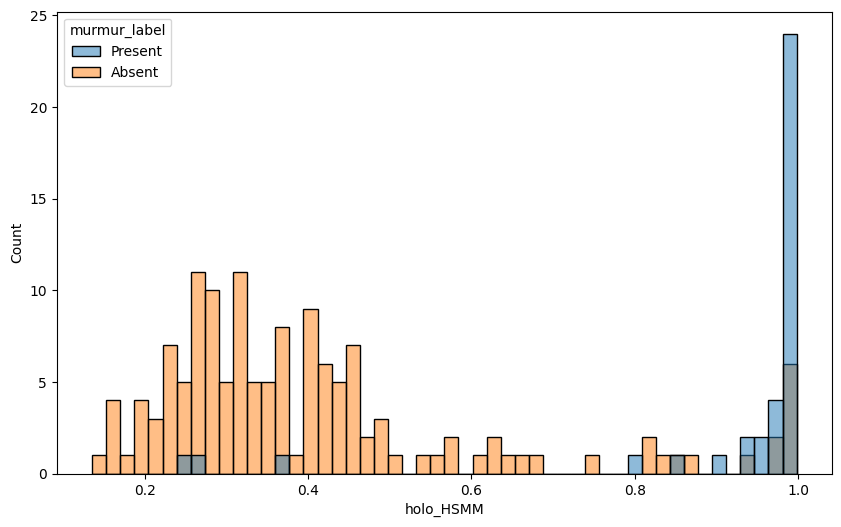

In [85]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df.query("murmur_label != 'Unknown'"), x= 'holo_HSMM', hue= "murmur_label", bins= 50)